In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from net import *
from utils import *
from loss import *

In [2]:
## parameters
img_root = "D:/nyc_taxi/data-3d"
mask_root = "D:/nyc_taxi/data-3d"
mask_type = 'biased'
image_size = 64
chunk_size = 2
test_imgs = np.load(img_root+'/test.npy')
test_masks_biased = np.load(mask_root+'/test_biased_mask.npy')
dataset_test = taxi_data(test_imgs, test_masks_biased, image_size, chunk_size)

## load models
model_l1 = PConvUNet(input_channels=1)
model_l1.load_state_dict(torch.load('model_states/biased_l1_2'))
model_relative = PConvUNet(input_channels=1)
model_relative.load_state_dict(torch.load('model_states/biased_relative_2'))

<All keys matched successfully>

### Visualization

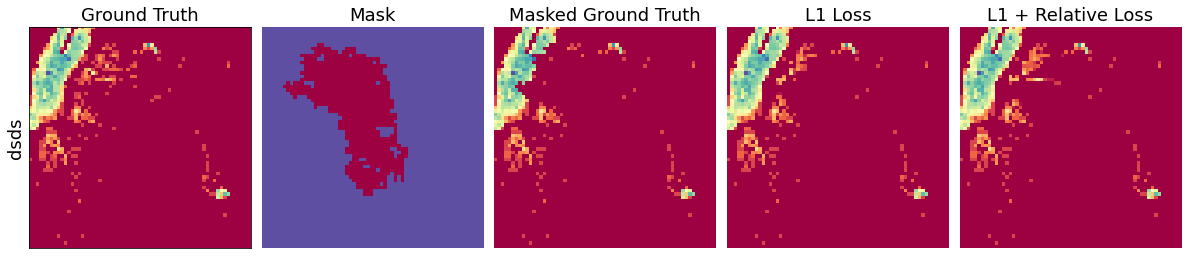

In [40]:
## param
color = 'Spectral'
all_time_max = 1428

## get test images
#indices = np.random.randint(chunk_size-1, len(dataset_test),num)
#indices = [1442, 1631, 220, 44, 1574]
#mask, gt = zip(*[dataset_test[i] for i in indices])
index = np.random.randint(2,len(dataset_test),1)[0]
mask, gt = dataset_test[index]
mask = mask.reshape(1,1,2,64,64)
gt = gt.reshape(1,1,2,64,64)
image = mask*gt
with torch.no_grad():
    output_l1, _ = model_l1(gt, mask)
    output_relative, _ = model_relative(gt, mask)
output_comp_l1 = mask * gt + (1 - mask) * output_l1
output_comp_relative = mask * gt + (1 - mask) * output_relative

## scale back + log transformation
gt = torch.log(gt*all_time_max+1) 
image = torch.log(image*all_time_max+1)
output_comp_l1 = torch.log(output_comp_l1*all_time_max+1)
output_comp_relative = torch.log(output_comp_relative*all_time_max+1)

## the last layer
gt = gt[:,:,-1,:,:]
mask = mask[:,:,-1,:,:]
image = image[:,:,-1,:,:]
output_comp_l1 = output_comp_l1[:,:,-1,:,:]
output_comp_relative = output_comp_relative[:,:,-1,:,:]

plt.figure(figsize=(20,20))
## ground truth
plt.subplot(1, 5, 1)
plt.xticks([])
plt.yticks([])
plt.ylabel('dsds',fontsize=18)
plt.title('Ground Truth',fontsize=18)
plt.imshow(gt[0][0],cmap=color)
## mask
plt.subplot(1, 5, 2)
plt.axis('off')
plt.title('Mask',fontsize=18)
plt.imshow(mask[0][0], cmap=color)
## masked ground truth
plt.subplot(1, 5, 3)
plt.axis('off')
plt.title('Masked Ground Truth',fontsize=18)
plt.imshow(image[0][0],cmap=color)
## l1 loss
plt.subplot(1, 5, 4)
plt.axis('off')
plt.title('L1 Loss',fontsize=18)
plt.imshow(output_comp_l1[0][0],cmap=color)
## l1 + relative loss
plt.subplot(1, 5, 5)
plt.axis('off')
plt.title('L1 + Relative Loss',fontsize=18)
plt.imshow(output_comp_relative[0][0],cmap=color)
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.05,
                    hspace=0.5)
#plt.savefig(f'../visualizations/{ylabel}_{str(index)}.jpg',bbox_inches='tight', dpi=600)

index = 472

---

### Time Validity Check

In [45]:
## param
num = 6
COLOR = 'Spectral'
all_time_max = 1428
time = 48

## get test images
indices = list(range(time,time+24))
_, gt = zip(*[dataset_test[i] for i in indices])
gt = torch.stack(gt)
mask, _ = dataset_test[1417]
mask = np.repeat(mask.reshape(1,1,2,64,64),24,axis=0)
image = mask*gt
with torch.no_grad():
    output_l1, _ = model_l1(gt, mask)
    output_relative, _ = model_relative(gt, mask)
output_comp_l1 = mask * gt + (1 - mask) * output_l1
output_comp_relative = mask * gt + (1 - mask) * output_relative

## scale back + log transformation
gt = torch.log(gt*all_time_max+1) 
image = torch.log(image*all_time_max+1)
output_comp_l1 = torch.log(output_comp_l1*all_time_max+1)
output_comp_relative = torch.log(output_comp_relative*all_time_max+1)

## the last layer
gt = gt[:,:,-1,:,:]
mask = mask[:,:,-1,:,:]
image = image[:,:,-1,:,:]
output_comp_l1 = output_comp_l1[:,:,-1,:,:]
output_comp_relative = output_comp_relative[:,:,-1,:,:]

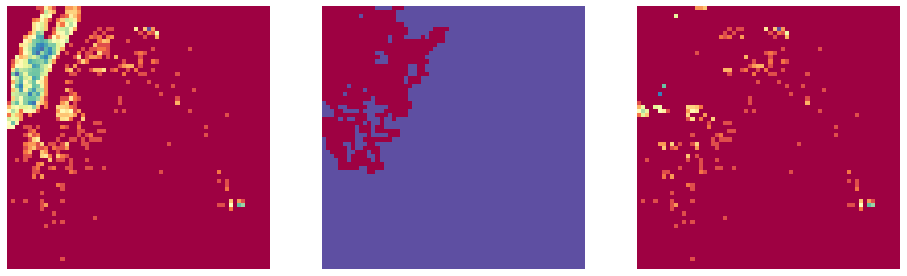

In [46]:
plt.figure(figsize=(16,16))
plt.subplot(1, 3, 1)
plt.axis('off')
plt.imshow(gt[0][0],cmap=COLOR)
plt.subplot(1, 3, 2)
plt.axis('off')
plt.imshow(mask[0][0], cmap=COLOR)
plt.subplot(1, 3, 3)
plt.axis('off')
plt.imshow(image[0][0], cmap=COLOR)
pass

In [47]:
gt_time_series = []
pred_time_series_l1 = []
pred_time_series_relative = []
for i in range(len(gt)):
    gt_time_series.append(torch.mean(gt[i][0][mask[i][0] == 0]).item())
    pred_time_series_l1.append(torch.mean(output_comp_l1[i][0][mask[i][0] == 0]).item())
    pred_time_series_relative.append(torch.mean(output_comp_relative[i][0][mask[i][0] == 0]).item())

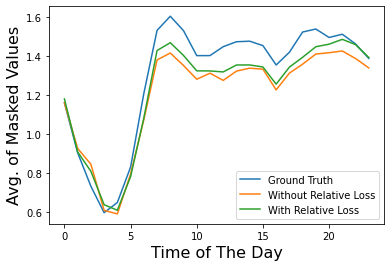

In [48]:
plt.plot(gt_time_series, label='Ground Truth')
plt.plot(pred_time_series_l1, label='Without Relative Loss')
plt.plot(pred_time_series_relative, label='With Relative Loss')
plt.legend()
plt.xlabel('Time of The Day', size=16)
plt.ylabel('Avg. of Masked Values', size=16)
pass

### Statistical Testing

In [33]:
parameters = {
    "img_root": "D:/nyc_taxi/data-3d",
    "mask_root": "D:/nyc_taxi/data-3d",
    "learning_rate_m": 0.001,
    "learning_rate_c": 0.001,
    "learning_rate_step": 1000,
    "max_iter": 20000,
    "eval_iter": 200,
    "batch_size": 16,
    "chunk_size": 1,
    "image_size": 64,
    "valid_loss_weight": 1,
    "hole_loss_weights": [0.1,0.5,1,2,3,4,5,6,7,8,9,10],
    "relative_loss_weights": [0.1,0.5,1,2,3,4,5,6,7,8,9,10],
    "prev_hour_loss_weights": [0.1,0.5,1,2,3,4,5,6,7,8,9,10],
    "epsilon": 1e-6,
    "all_time_max": 1428,
    "mask_types": ["biased"],
    "loss_types": ["1d", "3d", "relative"],
    'device':torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
}

In [41]:
def quantitative_eval(model1, model2, dataset, parameters):
    
    ## parameters
    device = parameters['device']
    batch_size = parameters['batch_size']
    chunk_size = parameters['chunk_size']
    all_time_max = parameters['all_time_max']
    all_results = []
    
    ## metrics
    model1_hole_l1_output = []
    model1_hole_mse_output = []
    model1_ssim_output_5 = []
    model1_ssim_output_7 = []
    model1_ssim_output_9 = []
    model1_psnr_output = []
    
    model2_hole_l1_output = []
    model2_hole_mse_output = []
    model2_ssim_output_5 = []
    model2_ssim_output_7 = []
    model2_ssim_output_9 = []
    model2_psnr_output = []
    
    ## iterate through
    permutation = torch.randperm(len(dataset))
    permutation = permutation[permutation>=chunk_size-1]
    for i in range(0, len(permutation), batch_size):
        indices = permutation[i:i+batch_size]
        mask, gt = zip(*[dataset[i] for i in indices])
        mask = torch.stack(mask).to(device)
        gt = torch.stack(gt).to(device)
        
        with torch.no_grad():
            model1_output, _ = model1(gt, mask)
            model2_output, _ = model2(gt, mask)
        model1_output_comp = mask * gt + (1 - mask) * model1_output
        model2_output_comp = mask * gt + (1 - mask) * model2_output
        
        ## scale back
        gt = (gt*all_time_max).cpu().detach().numpy()
        mask = mask.cpu().detach().numpy()        
        model1_output_comp = (model1_output_comp*all_time_max).cpu().detach().numpy()
        model2_output_comp = (model2_output_comp*all_time_max).cpu().detach().numpy()     
        
        ## take the last layer
        gt = gt[:,:,-1,:,:]
        mask = mask[:,:,-1,:,:]
        model1_output_comp = model1_output_comp[:,:,-1,:,:]
        model2_output_comp = model2_output_comp[:,:,-1,:,:]
        
        ## calculate ssim & partial mse
        for j in range(len(model1_output)):
            ## single image & output
            gt_single = gt[j][0]
            mask_single = mask[j][0]
            model1_output_comp_single = model1_output_comp[j][0]
            model2_output_comp_single = model2_output_comp[j][0]
            
            ## calculate metrics
            ## overall image
            model1_ssim_output_5.append(structural_similarity(model1_output_comp_single, gt_single, win_size=5))
            model1_ssim_output_7.append(structural_similarity(model1_output_comp_single, gt_single, win_size=7))
            model1_ssim_output_9.append(structural_similarity(model1_output_comp_single, gt_single, win_size=9))
            model1_psnr_output.append(peak_signal_noise_ratio(model1_output_comp_single, gt_single, data_range=all_time_max))

            model2_ssim_output_5.append(structural_similarity(model2_output_comp_single, gt_single, win_size=5))
            model2_ssim_output_7.append(structural_similarity(model2_output_comp_single, gt_single, win_size=7))
            model2_ssim_output_9.append(structural_similarity(model2_output_comp_single, gt_single, win_size=9))
            model2_psnr_output.append(peak_signal_noise_ratio(model2_output_comp_single, gt_single, data_range=all_time_max))            
            
            ## hole regions
            model1_output_comp_single_hole = model1_output_comp_single[np.where(mask_single == 0)]
            model2_output_comp_single_hole = model2_output_comp_single[np.where(mask_single == 0)]
            gt_single_hole = gt_single[np.where(mask_single == 0)]
            
            model1_hole_l1_output.append(np.mean(np.abs(model1_output_comp_single_hole - gt_single_hole)))
            model1_hole_mse_output.append(mean_squared_error(model1_output_comp_single_hole, gt_single_hole))
            model2_hole_l1_output.append(np.mean(np.abs(model2_output_comp_single_hole - gt_single_hole)))
            model2_hole_mse_output.append(mean_squared_error(model2_output_comp_single_hole, gt_single_hole))

    return {'model1': {'hole_l1_output':model1_hole_l1_output,
                       'hole_mse_output':model1_hole_mse_output,
                       'ssim_output_5':model1_ssim_output_5,
                       'ssim_output_7':model1_ssim_output_7,
                       'ssim_output_9':model1_ssim_output_9,
                       'psnr_output':model1_psnr_output},
           'model2': {'hole_l1_output':model2_hole_l1_output,
                      'hole_mse_output':model2_hole_mse_output,
                      'ssim_output_5':model2_ssim_output_5,
                      'ssim_output_7':model2_ssim_output_7,
                      'ssim_output_9':model2_ssim_output_9,
                      'psnr_output':model2_psnr_output}}

In [42]:
all_results = quantitative_eval(model_3d, model_relative, dataset_test, parameters)

In [63]:
from scipy.stats import ttest_ind
from scipy.stats import t
import scipy.stats as stats

In [69]:
print(stats.wilcoxon(all_results['model1']['hole_l1_output'], all_results['model2']['hole_l1_output'], alternative='greater'))
print(stats.wilcoxon(all_results['model1']['hole_mse_output'], all_results['model2']['hole_mse_output'], alternative='greater'))
print(stats.wilcoxon(all_results['model1']['ssim_output_5'], all_results['model2']['ssim_output_5'], alternative='less'))
print(stats.wilcoxon(all_results['model1']['ssim_output_7'], all_results['model2']['ssim_output_7'], alternative='less'))
print(stats.wilcoxon(all_results['model1']['ssim_output_9'], all_results['model2']['ssim_output_9'], alternative='less'))
print(stats.wilcoxon(all_results['model1']['psnr_output'], all_results['model2']['psnr_output'], alternative='less'))

WilcoxonResult(statistic=3512792.0, pvalue=4.784423046977545e-05)
WilcoxonResult(statistic=3376710.0, pvalue=0.041558906106230434)
WilcoxonResult(statistic=2286642.0, pvalue=2.043839231334878e-55)
WilcoxonResult(statistic=2484395.0, pvalue=4.4673583748251284e-36)
WilcoxonResult(statistic=2526643.0, pvalue=1.681919051274172e-32)
WilcoxonResult(statistic=3121883.0, pvalue=0.009965028809850694)
